In [2]:
from numpy import genfromtxt
import tensorflow as tf
import tensorflow.keras as keras
'''#from keras.models import Sequential
from keras.layers import Dense, Input, Lambda, Dropout
from keras import regularizers
#from keras.layers import Dropout
from keras.constraints import maxnorm
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras import regularizers
#from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras import objectives
from keras.models import model_from_json
from keras.layers import Input, Dense, Convolution1D, MaxPooling1D, UpSampling1D, AveragePooling1D, Flatten ,Reshape,ZeroPadding1D,Cropping1D
from keras.models import Model
#from keras.callbacks import TensorBoard
from keras.regularizers import l2, l1
from keras import optimizers
from keras.layers.noise import GaussianNoise
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.layers import Dense,concatenate, Input,TimeDistributed,LSTM, Lambda, Dropout, Reshape, Conv1D, Flatten, UpSampling1D, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras import backend as K'''
from PIL import Image

import os
import sys
import itertools
#import keras_internal_model
import pandas as pd
import numpy as np
#import train_tools as tt
from numpy import genfromtxt
from time import time

import csv

tf.compat.v1.enable_v2_behavior()


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)
    
    
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_logical_devices('GPU')

import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

GPUs:  1


In [23]:
def n2c(n,stride=180): #number to coordinate
    row = n//stride
    col = n%stride
    return (row,col)

def c2n(c,stride=180): #coordinate to number
    return c[0]*stride + c[1]



In [24]:
dataset_path = '/home/pico/uni/romi/rl_sony/arabidopsis_image_sets'
plants = ['000_2d', '001_2d','003_2d','006_2d','009_2d']

dest_path = '/home/pico/uni/romi/rl_sony/supervised_learning/data'
#if not os.path.exists(dest_path):
#    os.makedirs(dest_path)

sample_files_path = os.path.join(dest_path,'raw_samples')

In [28]:
plant = '000_2d'
df = pd.read_csv(os.path.join(sample_files_path, plant+'_classifier_samples.csv'),
                header=['i0','i1','i2','i3'],
                usecols=(0,1,2,3))

ValueError: header must be integer or list of integers

In [26]:
df.head()

,130,129,672,152,3.346346753436619,3.1905858538885914,2.9849759833340923,2.8592197952016605,2.778115809461812,2.7414990506034993,...,3.9993693990876023,3.9508115573647085,3.887359227778998,3.8138759975267575,3.757078912936063,3.692028667408092,3.6617987193866806,3.5918539384825365,3.5467426716583117,3.4900446396416664
0,16,212,50,36,2.095825,1.845990,1.625859,1.455313,1.388480,1.358760,...,2.229699,2.195776,2.159239,2.131034,2.113553,2.095273,2.093895,2.111382,2.130441,2.146685
1,610,596,609,240,2.844349,2.811218,2.800986,2.806857,2.774934,2.715718,...,4.272653,4.293238,4.294151,4.305179,4.288358,4.301647,4.280296,4.278563,4.245432,4.253695
2,580,587,421,41,1.720369,1.775860,1.817424,1.838625,1.857696,1.838858,...,2.295139,2.279029,2.270538,2.266389,2.249724,2.246579,2.236685,2.233920,2.224944,2.221321
3,524,348,180,16,2.251956,2.243119,2.257362,2.316468,2.428631,2.453351,...,2.300255,2.278540,2.270896,2.271310,2.252579,2.229838,2.210707,2.202376,2.190642,2.180041
4,512,673,692,172,3.433645,3.583463,3.646599,3.611160,3.464750,3.263902,...,3.919883,3.893079,3.842710,3.813022,3.815614,3.879196,3.932251,3.945653,3.969694,4.025236


In [7]:
a = cv2.imread(os.path.join(plant001,'000_000.png'),0)
b = cv2.imread(os.path.join(plant001,'000_001.png'),0)
c = cv2.imread(os.path.join(plant001,'003_002.png'),0)

In [8]:
merged = np.stack((a,b,c),axis=2)

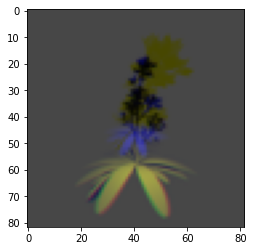

In [9]:
plt.imshow(merged[:,:,:], cmap='gray', vmin=0, vmax=255)

In [10]:
merged.shape

(82, 82, 3)

In [15]:
cv2.imwrite('test.png',merged)

True

In [52]:
a = list (os.walk(dataset_path))

In [16]:
d = cv2.imread('test.png')

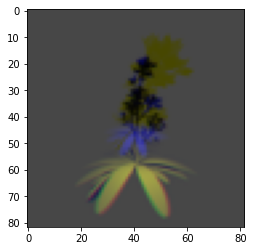

In [17]:
plt.imshow(merged[:,:,:], cmap='gray', vmin=0, vmax=255)

In [18]:
(merged==d).all()

True